In [52]:
#!/usr/bin/python
# encoding=utf8
import sys
reload(sys)
sys.setdefaultencoding('utf8')

import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy import odr
import pylab as py
from matplotlib import gridspec

from redTools import *
from Kcorrect import *
################################################################# 
def add_axis(ax, xlim, ylim):
    
    x1, x2 = xlim[0], xlim[1]
    y1, y2 = ylim[0], ylim[1]
    ax.set_xlim(x1, x2)
    ax.set_ylim(y1, y2)

    ax.minorticks_on()
    ax.tick_params(which='major', length=5, width=1.0)
    ax.tick_params(which='minor', length=2, color='#000033', width=1.0)     
    
    # additional Y-axis (on the right)
    y_ax = ax.twinx()
    y_ax.set_ylim(y1, y2)
    y_ax.set_yticklabels([])
    y_ax.minorticks_on()
    y_ax.tick_params(which='major', length=5, width=1.0, direction='in')
    y_ax.tick_params(which='minor', length=2, color='#000033', width=1.0, direction='in')

    # additional X-axis (on the top)
    x_ax = ax.twiny()
    x_ax.set_xlim(x1, x2)
    x_ax.set_xticklabels([])
    x_ax.minorticks_on()
    x_ax.tick_params(which='major', length=5, width=1.0, direction='in')
    x_ax.tick_params(which='minor', length=2, color='#000033', width=1.0, direction='in')
    

########################################################### Begin

inFile  = 'ESN_HI_catal.csv'
table   = np.genfromtxt(inFile , delimiter=',', filling_values=-1, names=True, dtype=None)

table = extinctionCorrect(table)
table = Kcorrection(table)

band1 = 'r'
band2 = 'w2'

if band2=='w1':
    text1 = band1+'-W1'            # example: cr-W1
    text2 = '$c21W_1$'              # example: c21w
else: 
    text1 = band1+'-W2' 
    text2 = '$c21W_2$'

delta = np.abs(table[band2]-table[band2+'_'])
index, = np.where(delta<=0.15)
table = trim(table, index)

delta = np.abs(table[band1]-table[band1+'_'])
index, = np.where(delta<=0.15)
table = trim(table, index)

table['c21w'] = table['m21'] - table[band2]
table['r_w1'] = table[band1] - table[band2]

table['Ec21w'] = np.sqrt(table['m21_e']**2+0.05**2)
table['Er_w1'] = 0.*table['r_w1']+0.1

index, = np.where(table['logWimx']>1)
table = trim(table, index)

index, = np.where(table['r_w1']<4)
table = trim(table, index)

index, = np.where(table['r_w1']>-5)
table = trim(table, index)

index, = np.where(table['inc']>50)
table = trim(table, index)

In [53]:
pgc = table['pgc']
logWimx = table['logWimx']
logWimx_e = table['logWimx_e']
inc = table['inc']
r_w1 = table['r_w1']
c21w = table['c21w'] 
Er_w1 = table['Er_w1']
Ec21w = table['Ec21w']


C82  = table['C82_w2']   # concentration 80%/20%
mu50 = table['w2']+2.5*np.log10(2.*np.pi*(table['R50_w2']*60)**2)

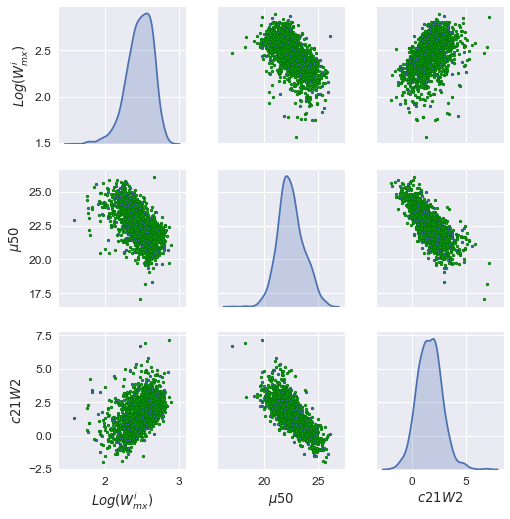

In [54]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('axes',edgecolor='k')

data = {'$Log( W_{mx}^i)$':logWimx, '$c21W2$':c21w, '$\mu 50$':mu50}
d = pd.DataFrame.from_dict(data)

sns.set(font_scale=1.2)

pp = sns.pairplot(d, diag_kind="kde", markers=".",plot_kws=dict(s=20, edgecolor="g", linewidth=1),diag_kws=dict(shade=True))



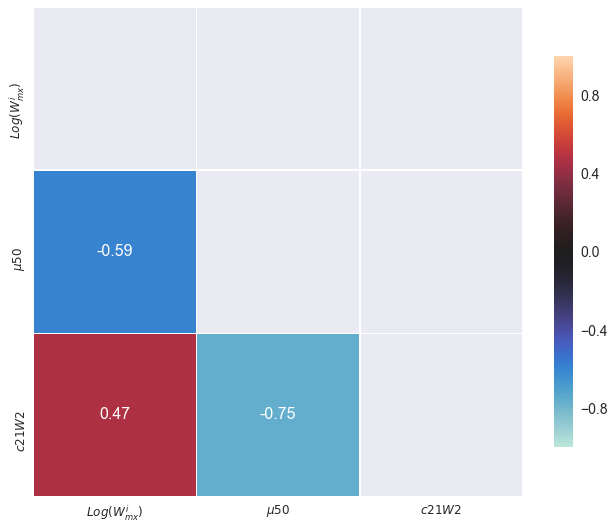

In [55]:
### Compute the correlation matrix
corr = d.corr()

### Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

### Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

### Generate a custom diverging colormap
#cmap = sns.diverging_palette(110, 20, as_cmap=False)

sns.set(font_scale=1.4)

### Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, vmin=-1,vmax=1.0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .8}, annot_kws={"size": 16}, annot=True, mask=mask)


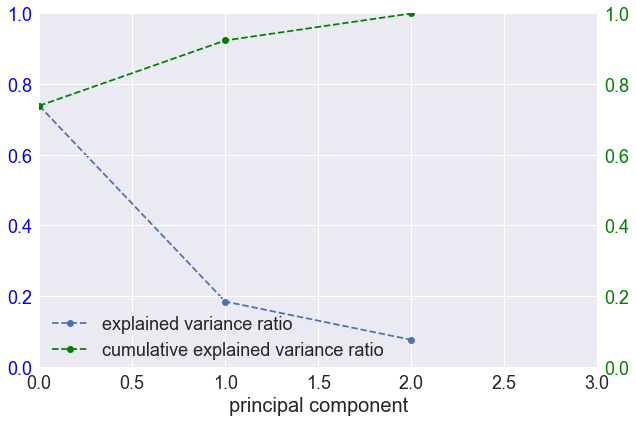

In [56]:
import sklearn.datasets as ds
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

z_scaler = StandardScaler()

data = {'$Log( W_{mx}^i)$':logWimx, '$c21W2$':c21w, '$\mu 50$':mu50}

d = pd.DataFrame.from_dict(data)
z_data = z_scaler.fit_transform(d)
pca_trafo = PCA().fit(z_data);


fig, ax1 = plt.subplots(figsize = (10,6.5))
ax1.plot(pca_trafo.explained_variance_ratio_, '--o', label = 'explained variance ratio');
color =  ax1.lines[0].get_color()
ax1.set_xlabel('principal component', fontsize = 20);
for tl in ax1.get_yticklabels():
    tl.set_color('b')
    
plt.legend(loc=(0.01, 0.075) ,fontsize = 18);

ax1.set_ylim([0,1])

ax2 = ax1.twinx()
ax2.plot(pca_trafo.explained_variance_ratio_.cumsum(), '--go', label = 'cumulative explained variance ratio');
for tl in ax2.get_yticklabels():
    tl.set_color('g')

ax1.tick_params(axis='both', which='major', labelsize=18);
ax1.tick_params(axis='both', which='minor', labelsize=12);
ax2.tick_params(axis='both', which='major', labelsize=18);
ax2.tick_params(axis='both', which='minor', labelsize=12);
plt.xlim([0, 3]);
ax2.set_ylim([0,1])
plt.legend(loc=(0.01, 0),fontsize = 18);

#data = {'$Log( W_{mx}^i)$':logWimx, '$c21W1$':c21w, 'C82': C82, '$\mu 50$':mu50}

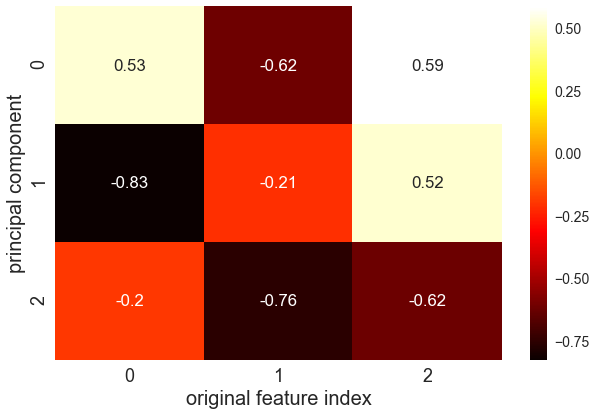

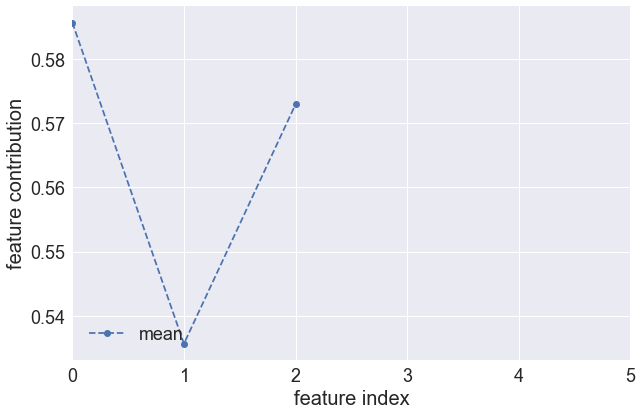

In [57]:
n_comp =3

pca_data = pca_trafo.fit_transform(z_data)
pca_inv_data = pca_trafo.inverse_transform(np.eye(n_comp))

fig = plt.figure(figsize=(10, 6.5))
sns.heatmap(pca_trafo.inverse_transform(np.eye(n_comp)), cmap="hot", cbar=True, annot=True)
plt.ylabel('principal component', fontsize=20);
plt.xlabel('original feature index', fontsize=20);
plt.tick_params(axis='both', which='major', labelsize=18);
plt.tick_params(axis='both', which='minor', labelsize=12);

fig = plt.figure(figsize=(10, 6.5))
A = pca_trafo.explained_variance_ratio_
#A[2]=0; A[3]=0
j=n_comp-1
while j>1: 
    A[j]=0
    j=j-1
importance =  (np.matmul(A,np.abs(pca_inv_data)))/(A[0]+A[1])
plt.plot(importance, '--o', label = 'mean')

#pca_trafo.explained_variance_ratio_
#print np.abs(pca_inv_data)
#print pca_trafo.explained_variance_ratio_

#plt.plot(np.square(pca_inv_data.std(axis=0)), '--o', label = 'variance')
plt.legend(loc='lower right')
plt.ylabel('feature contribution', fontsize=20);
plt.xlabel('feature index', fontsize=20);
plt.tick_params(axis='both', which='major', labelsize=18);
plt.tick_params(axis='both', which='minor', labelsize=12);
plt.xlim([0, 5])
plt.legend(loc='lower left', fontsize=18)

#data = {'$Log( W_{mx}^i)$':logWimx, '$c21W1$':c21w, 'C82': C82, '$\mu 50$':mu50}